# Supply Chain Shipment Pricing Prediction

## Background
In this study, analysis and pricing prediction is applied to supply chain shipment data. Models which will be explored during this analysis are listed and described below:

| Algorithm                                | Definition                                                                                                       | Characteristic                                                                                    |
|------------------------------------------|------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| Gradient boosted trees model (GBT Model) | Each tree is trained to predict and then "correct" for the errors of the previously trained trees                | A set of shallow decision trees trained sequentially.                                             |
| Multiple linear regression (MLR)         | A statistical technique for estimating a predictive target utilizing a linear relationship between two or more predictive factors for one predictive target. | Predicts a dependent variable using multiple independent variables.                               |
| Deep neural network (DNN)                | An artificial neural network consisting of many hidden layers between an input and output layer.                 | This algorithm can model complex nonlinear relationships, and it contains multiple hidden layers. |
| XGBoost regression                       | Extreme gradient boosting acting as an improved algorithm based on the gradient boosting algorithm.              | Excellent efficiency, flexibility, and portability, and it can prevent overfitting.               |
| LightGBM regression                      | Gradient boost-based algorithm that includes two techniques. (1) Gradient based on one-side sampling and (2) exclusive feature bundling. | An ensemble technique that utilizes a leaf-wise tree partitioning method.                         |

### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import math

In [2]:
plt.style.use(['science', 'notebook', 'ieee'])

## Data Collection and Preprocessing

### Data Collection
This data set provides supply chain health commodity shipment and pricing data. Specifically, the data set identifies Antiretroviral (ARV) and HIV lab shipments to supported countries. In addition, the data set provides the commodity pricing and associated supply chain expenses necessary to move the commodities to countries for use. The dataset has similar fields to the Global Fund's Price, Quality and Reporting (PQR) data. PEPFAR and the Global Fund represent the two largest procurers of HIV health commodities. This dataset, when analyzed in conjunction with the PQR data, provides a more complete picture of global spending on specific health commodities. The data are particularly valuable for understanding ranges and trends in pricing as well as volumes delivered by country. The US Government believes this data will help stakeholders make better, data-driven decisions. Care should be taken to consider contextual factors when using the database. Conclusions related to costs associated with moving specific line items or products to specific countries and lead times by product/country will not be accurate.


In [3]:
# Load the data set into Pandas DataFrame
dataset_df = pd.read_csv("Supply_Chain_Shipment_Pricing_Data.csv")

dataset_df.tail()

,id,project code,pq #,po / so #,asn/dn #,country,managed by,fulfill via,vendor inco term,shipment mode,...,unit of measure (per pack),line item quantity,line item value,pack price,unit price,manufacturing site,first line designation,weight (kilograms),freight cost (usd),line item insurance (usd)
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",False,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,...,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,False,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,...,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,False,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,True,1392,Freight Included in Commodity Cost,134.03
10323,86823,103-ZW-T30,FPQ-15197,SO-50022,DN-4336,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,...,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",False,Weight Captured Separately,Freight Included in Commodity Cost,85.82


### Data Preprocessing

In [4]:
dataset_df_reduced = dataset_df.copy()

dataset_df_reduced['weight (kilograms)'] = pd.to_numeric(dataset_df_reduced['weight (kilograms)'], errors = 'coerce')
dataset_df_reduced.dropna(inplace = True)

dataset_df_reduced['freight cost (usd)'] = pd.to_numeric(dataset_df_reduced['freight cost (usd)'], errors = 'coerce')
dataset_df_reduced.dropna(inplace = True)

In [5]:
# Explore country count data.
CountryCount_raw = dataset_df['country'].value_counts().nlargest(10).to_dict()
CountryCount_reduced = dataset_df_reduced['country'].value_counts().nlargest(10).to_dict()
CountryCount_raw


{'South Africa': 1406,
 'Nigeria': 1194,
 "Côte d'Ivoire": 1083,
 'Uganda': 779,
 'Vietnam': 688,
 'Zambia': 683,
 'Haiti': 655,
 'Mozambique': 631,
 'Zimbabwe': 538,
 'Tanzania': 519}

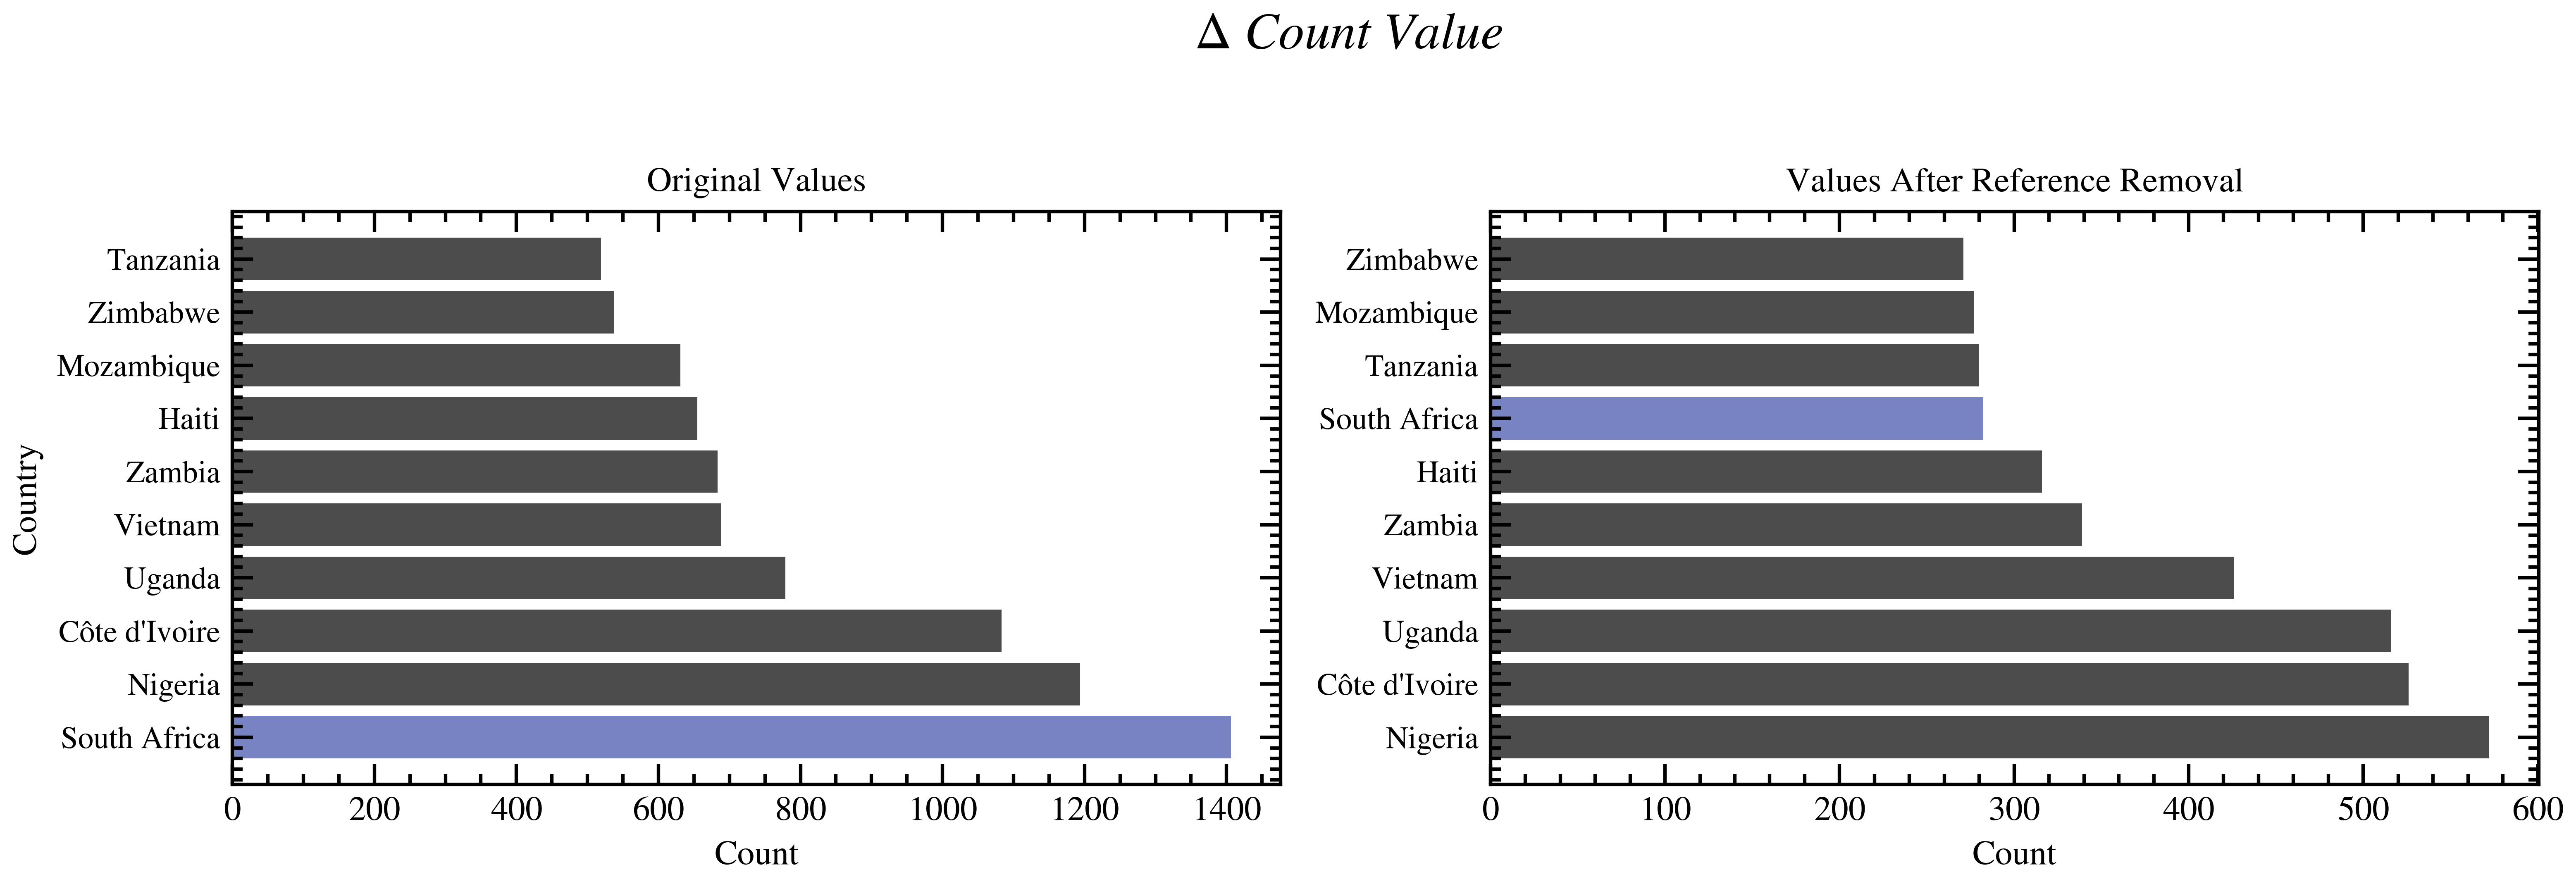

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes[0]
ax.barh(list(CountryCount_raw.keys()), list(CountryCount_raw.values()), color=('#3f4eab', 'k', 'k', 'k', 'k',
                                                                               'k', 'k', 'k', 'k', 'k'), alpha=0.7)
ax.set_title('Original Values', fontsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.set_ylabel('Country', fontsize=10)
ax.set_xlabel('Count', fontsize=10)
ax = axes[1]
fig.text(0.5, 1.1, '$\Delta \ Count \ Value$', ha='center', fontsize=15)
ax.barh(list(CountryCount_reduced.keys()), list(CountryCount_reduced.values()), color=('k', 'k', 'k', 'k', 'k',
                                                                                       'k', '#3f4eab', 'k', 'k', 'k'), alpha=0.7)
ax.set_title('Values After Reference Removal', fontsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.set_xlabel('Count', fontsize=10)
plt.show()

Country count values are represented greatly by South Africa, Nigeria, and Côte d'Ivoire with values over 1000. South Africa was most effected from this preprocessing step, having utilized over 1000 records which did not contain a numerical value for weight and/or freight price.

In [7]:
# Describe numerical values before removal section
dataset_df.describe()

,id,unit of measure (per pack),line item quantity,line item value,pack price,unit price,line item insurance (usd)
count,10324.000000,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,51098.968229,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,31944.332496,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,12795.750000,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000
50%,57540.500000,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
75%,83648.250000,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000
max,86823.000000,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


In [14]:
# Describe manufacturing origin.
ManLocs_raw = dataset_df.groupby('manufacturing site').size().nlargest(10).to_dict()
ManLocs_reduced = dataset_df_reduced.groupby('manufacturing site').size().nlargest(10).to_dict()
ManLocs_raw
ManLocs_reduced

{'Aurobindo Unit III, India': 1577,
 'Mylan (formerly Matrix) Nashik': 887,
 'Hetero Unit III Hyderabad IN': 484,
 'Cipla, Goa, India': 353,
 'Strides, Bangalore, India.': 315,
 'ABBVIE Ludwigshafen Germany': 265,
 'ABBVIE (Abbott) Logis. UK': 120,
 'Aurobindo Unit VII, IN': 77,
 'Aspen-OSD, Port Elizabeth, SA': 75,
 'MSD, Haarlem, NL': 62}

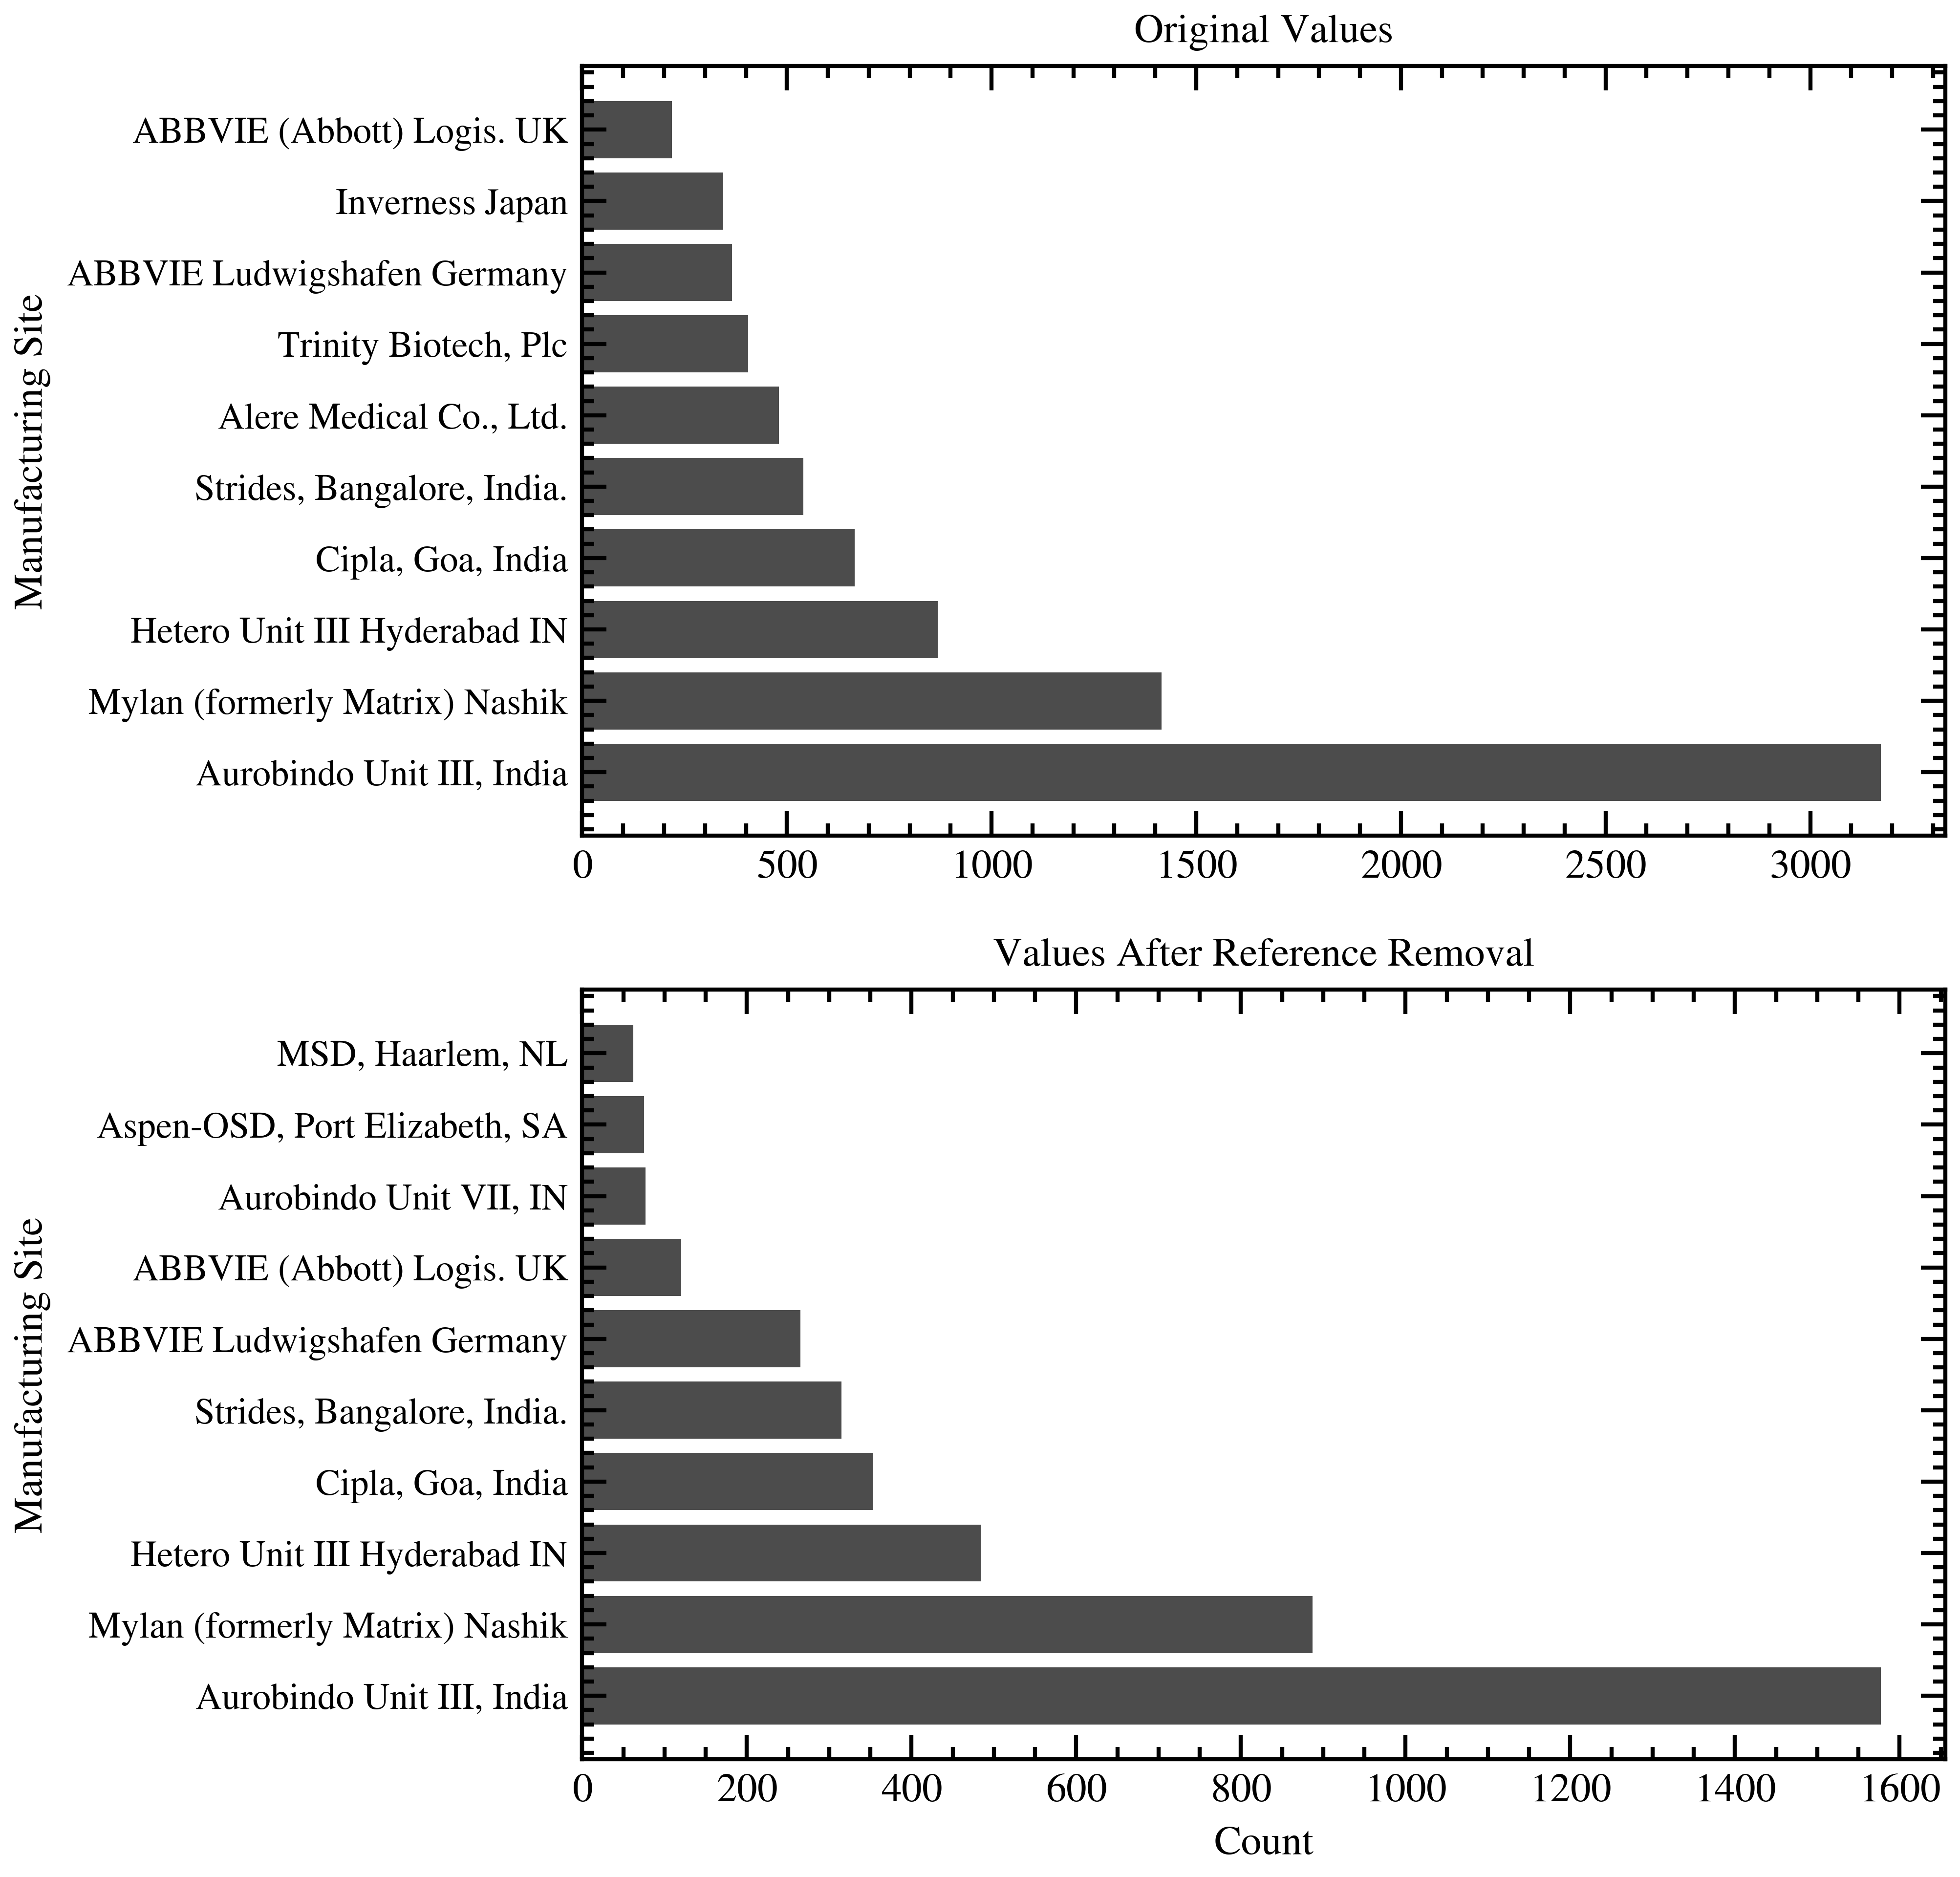

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(6, 7.5))
ax = axes[0]
ax.barh(list(ManLocs_raw.keys()), list(ManLocs_raw.values()), color=('k', 'k', 'k', 'k', 'k',
                                                                               'k', 'k', 'k', 'k', 'k'), alpha=0.7)
ax.set_title('Original Values', fontsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.set_ylabel('Manufacturing Site', fontsize=10)
ax = axes[1]
ax.barh(list(ManLocs_reduced.keys()), list(ManLocs_reduced.values()), color=('k', 'k', 'k', 'k', 'k',
                                                                                       'k', 'k', 'k', 'k', 'k'), alpha=0.7)
ax.set_title('Values After Reference Removal', fontsize=10)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.set_ylabel('Manufacturing Site', fontsize=10)
ax.set_xlabel('Count', fontsize=10)
plt.show()